# Pythagorean Triples via Grover's Algorithm
##### Elijah Kin
Here we attempt to generate Pythagorean triples on a quantum computer by means of Grover's algorithm.

In [1]:
import numpy as np
import qiskit

from qiskit import transpile, QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import MultiplierGate, HalfAdderGate
from qiskit.visualization import plot_histogram

In [2]:
print(qiskit.__version__)

# backend = Aer.get_backend('aer_simulator')
backend = Aer.get_backend('aer_simulator_matrix_product_state')

1.3.2


### Squaring a Register
We will first design a circuit which sends $|a\rangle |0\rangle \mapsto |a\rangle |a^2\rangle$.

In [3]:
# Create circuit for squaring a
def SquareGate(n):
  qc = QuantumCircuit(4 * n)
  # Probably not the most efficient way to do this...
  qc.cx(range(n), range(n, 2 * n))
  return qc.compose(MultiplierGate(n))

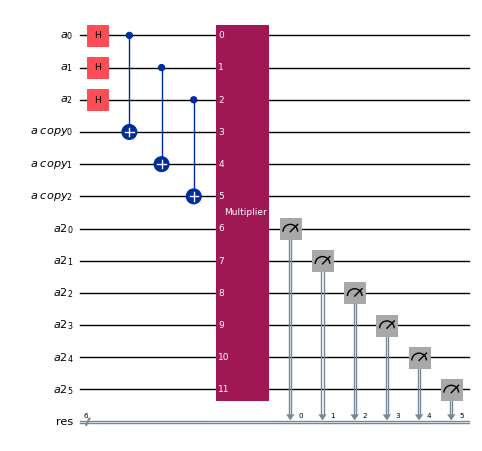

In [4]:
n = 3
qr_a = QuantumRegister(n, name='a')
ar_a = AncillaRegister(n, name='a copy')
qr_a2 = QuantumRegister(2 * n, name='a2')
cr_a2 = ClassicalRegister(2 * n, name='res')

qc = QuantumCircuit(qr_a, ar_a, qr_a2, cr_a2)
qc.h(qr_a)
qc.compose(SquareGate(len(qr_a)), inplace=True)
qc.measure(qr_a2, cr_a2)

qc.draw('mpl', scale=0.5)

In [5]:
qc_opt = transpile(qc, backend=backend, optimization_level=2)

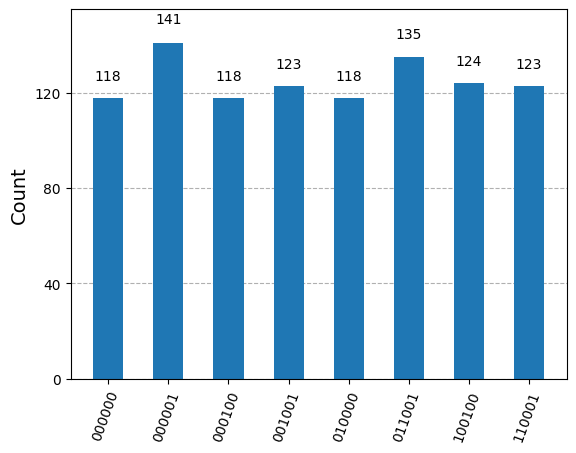

In [6]:
results = backend.run(qc_opt, shots=1000).result()
plot_histogram(results.get_counts())

We see that the above indeed works; the measured states correspond exactly to the perfect squares: $0, 1, 4, 9, 16, 25, 36, 49$

### Designing the Oracle

In [7]:
# Oracle that returns 1 if a Pythagorean triple is found
def oracle_pythag(n):
  # Needs 4n qubits to compute each square
  qc = QuantumCircuit(12 * n + 2, 10)

  # Make copies of a, b, and c
  qc.cx(range(9), range(9, 18))

  # Compute the squares a^2, b^2, and c^2
  qc.compose(MultiplierGate(n), [0, 1, 2] + [9, 10, 11] + [18, 19, 20, 21, 22, 23], inplace=True)
  qc.compose(MultiplierGate(n), [3, 4, 5] + [12, 13, 14] + [24, 25, 26, 27, 28, 29], inplace=True)
  qc.compose(MultiplierGate(n), [6, 7, 8] + [15, 16, 17] + [30, 31, 32, 33, 34, 35], inplace=True)

  # Add a^2 and b^2
  qc.compose(HalfAdderGate(2 * n), qubits=[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 36], inplace=True)

  # Check if each qubit of a^2 + b^2 and c^2 are equal
  qc.cx([30, 31, 32, 33, 34, 35, 37], [24, 25, 26, 27, 28, 29, 36])
  qc.x([24, 25, 26, 27, 28, 29, 36])

  # MCX on all equality qubits
  qc.mcx([24, 25, 26, 27, 28, 29, 36], 37)
  return qc

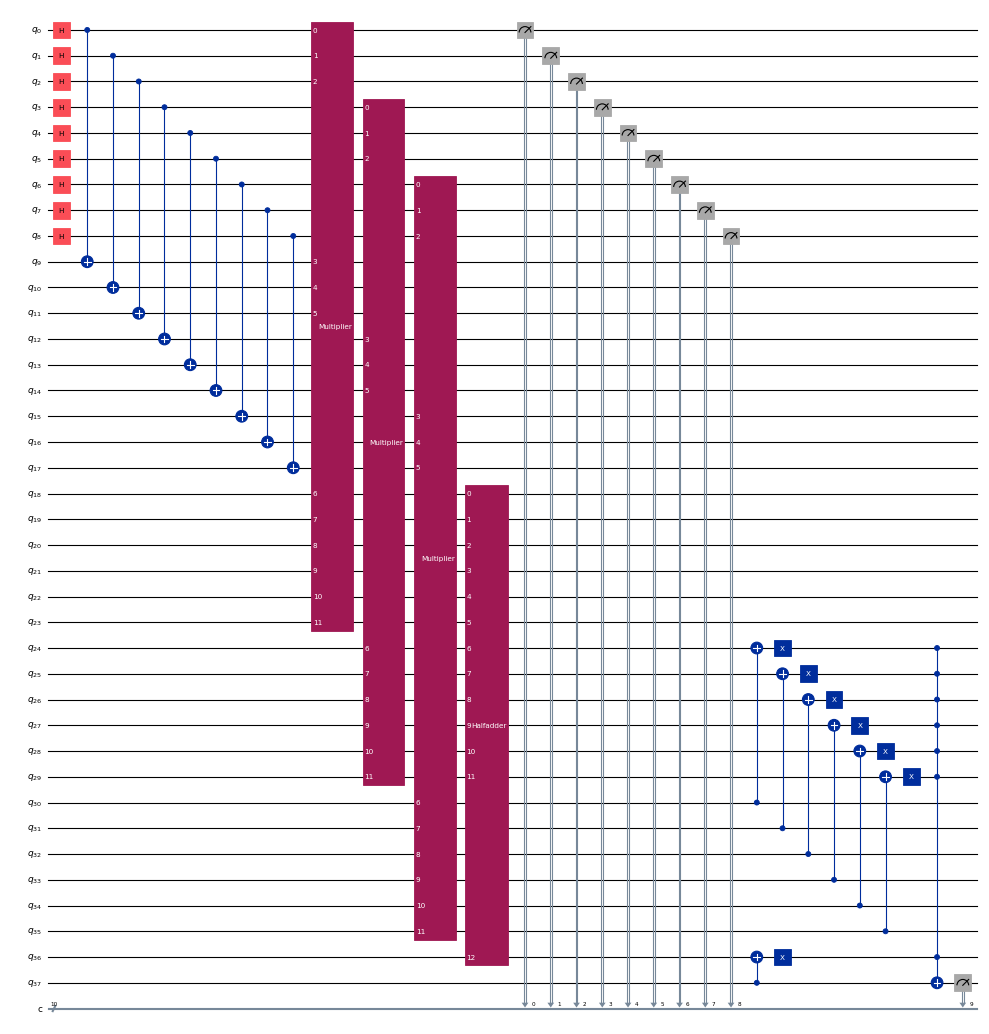

In [8]:
qc_pythag = QuantumCircuit(12 * n + 2, 10)
qc_pythag.h(range(9))
qc_pythag.compose(oracle_pythag(3), inplace=True)
qc_pythag.measure(list(range(9)) + [37], range(10))
qc_pythag.draw('mpl', fold=-1, scale=0.4)

In [9]:
qc_pythag_opt = transpile(qc_pythag, backend=backend, optimization_level=2)

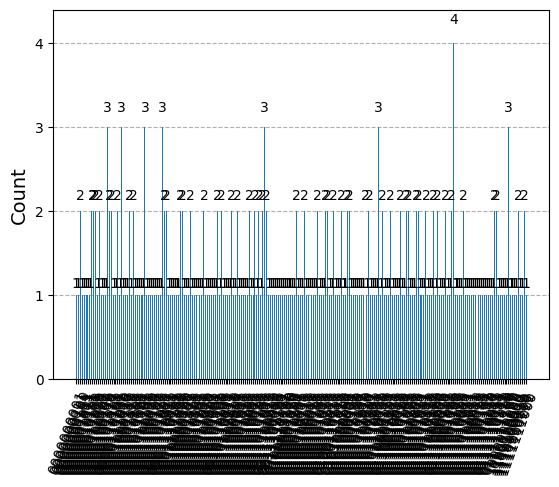

In [10]:
results = backend.run(qc_pythag_opt, shots=300).result()
plot_histogram(results.get_counts())

In [11]:
for key in results.get_counts().keys():
  if key[0] == '1':
    triple = ''
    for i in range(1, len(key), 3):
      triple += str(int(key[i : i + 3], base=2))
      triple += ' '
    print(triple)

7 0 7 
7 7 0 
2 2 0 
4 4 0 
6 0 6 
5 4 3 
0 0 0 
6 6 0 


We see that we correctly implement the check for Pythagorean triples.

### Implementing Grover's Algorithm

In [12]:
# Diffusion (sandwiched reflection) operator

def diffuser(q, label='diffuser'):
    qc = QuantumCircuit(q)
    n = qc.num_qubits
    qc.h([q[i] for i in range(n-1)])
    qc.x([ q[i] for i in range(n-1) ])
    if n > 2:
        # for multi-controlled Z use multi-controlled Z rotation
        qc.mcrz(np.pi, q[0:n-2], q[n-2])
    else:
        # for one-qubit oracles no controls
        qc.z(q[0])
    qc.barrier()
    qc.x([ q[i] for i in range(n-1) ])
    qc.h([ q[i] for i in range(n-1) ])
    return qc

In [13]:
def grover(nqubits, oracle, iterations=1, measure=True):

    q = QuantumRegister(nqubits, name='q') # create the quantum register
    if(measure):
    # measure only qubits that are input to the oracle
        creg = ClassicalRegister(10, name='c')
        qc = QuantumCircuit(q,creg)         # create the circuit
    else:
        qc = QuantumCircuit(q)           # circuit without measurements

    # initialize the circuit:
    # the qubit that receives the oracle output must be set to |1>
    qc.x(nqubits-1)
    qc.h(range(9))
    qc.save_statevector(label='init')

    # add repetitions of oracle plus diffusion operator
    for i in range(iterations):
        qc.compose(oracle, inplace=True)
        qc.barrier()
        qc.compose(diffuser(QuantumRegister(10)), list(range(9)) + [37], inplace=True)
        qc.save_statevector(label=f"diffuser_{i}")

    if(measure):  # Measurements
        qc.measure(list(range(9)) + [nqubits - 1],creg)
    return qc

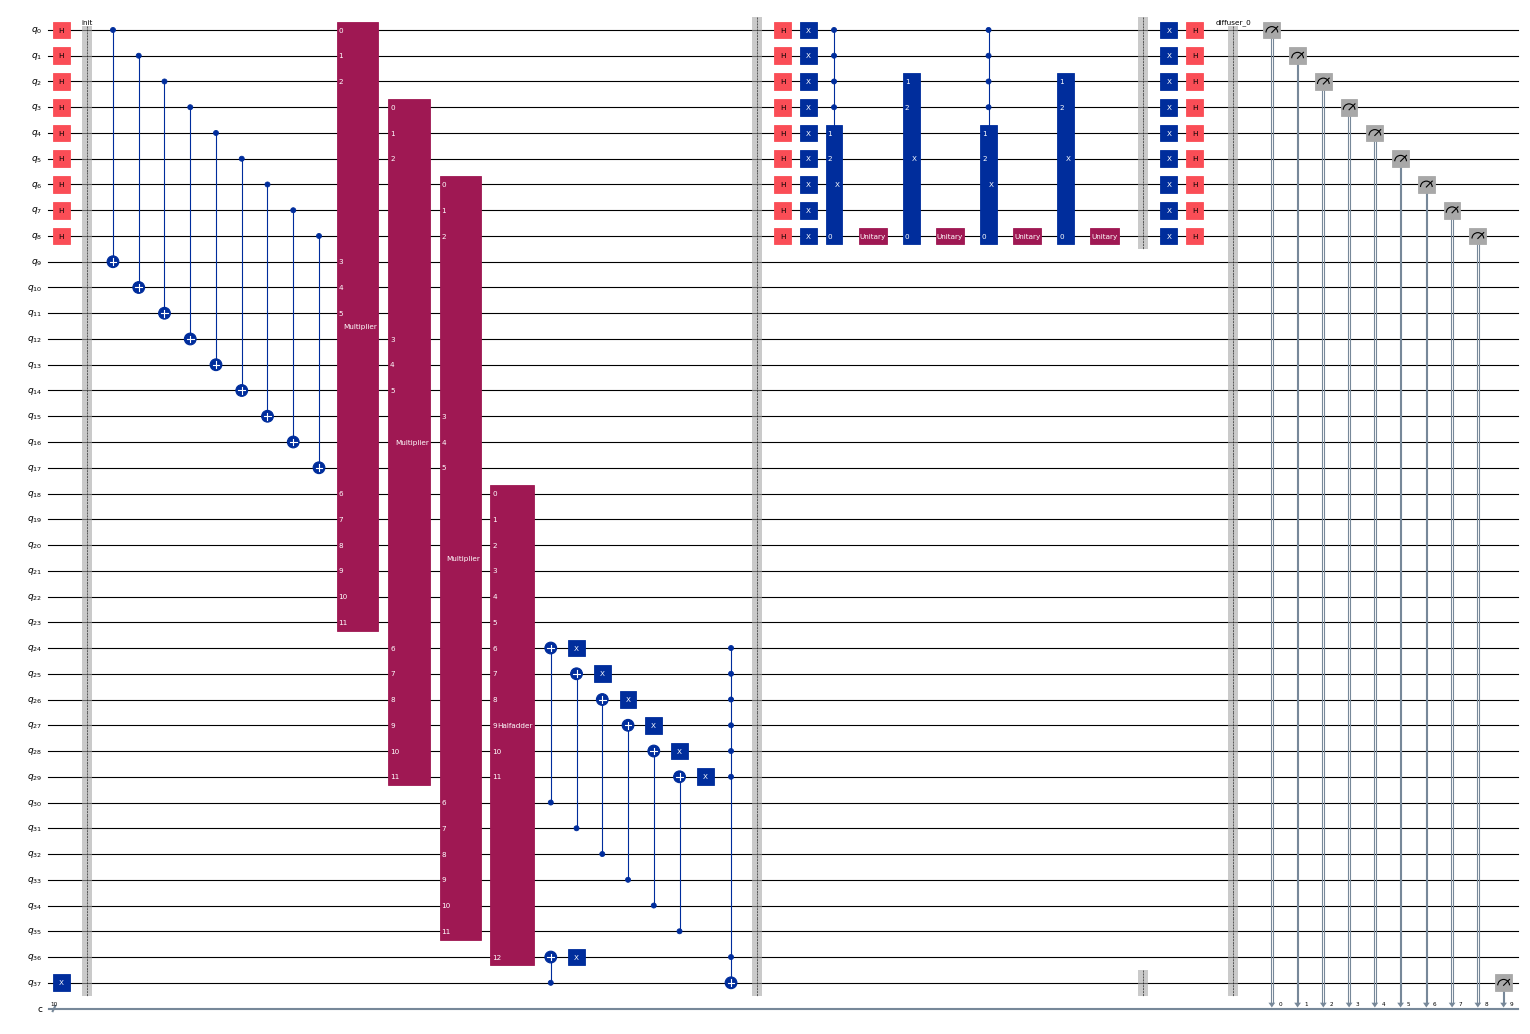

In [ ]:
nqubits = 38

qc_grover = grover(nqubits, oracle_pythag(3))
qc_grover.draw(output = 'mpl', fold=-1, scale=0.4)

In [ ]:
qc_grover_opt = transpile(qc_grover, backend=backend, optimization_level=2)

: 

In [ ]:
results = backend.run(qc_grover_opt, shots=300).result()
plot_histogram(results.get_counts())